### Goal (Module 1: Pain-Adjusted Screen)
We want to select ETF components for a Defensive Growth portfolio by ranking ETFs on efficiency (return per unit of pain), not return alone.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../processed/etf_returns.csv', parse_dates=['Date'])

# Keep only what we need 
df = df[['Date', 'Ticker', 'Daily_Return']].dropna()

# Pivot to have tickers as columns
returns_wide = df.pivot(index='Date', columns='Ticker', values='Daily_Return').sort_index()

print("returns_wide shape:", returns_wide.shape)
print("Date Range:", returns_wide.index.min(), "to", returns_wide.index.max())
returns_wide.head()

returns_wide shape: (3094, 15)
Date Range: 1/10/2014 to 9/9/2025


Ticker,BND,IAU,MOAT,QUAL,QUS,SCHD,SPLV,SPY,VCN.TO,VDY.TO,VFV.TO,VTI,XIC.TO,ZAG.TO,ZLB.TO
Date,,,,,,,,,,,,,,,
1/10/2014,0.004293,0.005983,-0.013414,-0.014091,NaN,-0.012707,-0.007149,-0.013552,-0.010282,-0.009205,-0.016802,-0.013137,-0.008047,0.003207,-0.005170
1/10/2015,0.000538,-0.001855,-0.005013,-0.000165,0.000000,-0.001391,-0.001390,0.002609,-0.003451,-0.000729,-0.004182,0.002026,-0.005224,0.000000,-0.007648
1/10/2018,-0.001872,-0.002625,-0.000214,0.003762,0.004311,0.002830,-0.001009,0.003474,0.003379,0.002391,-0.005835,0.001537,0.002748,-0.005284,-0.005369
1/10/2019,0.000973,0.004965,-0.015952,-0.012662,-0.011942,-0.012961,-0.008463,-0.011895,-0.013405,-0.011239,-0.014719,-0.013046,-0.012835,-0.000621,-0.004919
1/10/2020,0.001022,0.008338,0.005129,0.005495,0.002853,-0.000542,0.002797,0.006420,0.003096,-0.004828,0.002519,0.008338,0.004300,0.000598,0.007134


In [3]:
print("Date range:", returns_wide.index.min(), "to", returns_wide.index.max())
print("Shape:", returns_wide.shape)
print("\nMissing % per ticker (top 10):")
display((returns_wide.isna().mean().sort_values(ascending=False).head(10) * 100).to_frame("missing_%"))

print("\nNon-null counts (top 10):")
display(returns_wide.notna().sum().sort_values(ascending=False).head(10).to_frame("non_null_days"))

Date range: 1/10/2014 to 9/9/2025
Shape: (3094, 15)

Missing % per ticker (top 10):


,missing_%
Ticker,
QUS,12.249515
ZAG.TO,2.003878
ZLB.TO,2.003878
XIC.TO,2.003878
VFV.TO,2.003878
VDY.TO,2.003878
VCN.TO,2.003878
SPLV,1.809955
SCHD,1.809955



Non-null counts (top 10):


,non_null_days
Ticker,
BND,3038
IAU,3038
MOAT,3038
QUAL,3038
SCHD,3038
SPLV,3038
SPY,3038
VTI,3038
VFV.TO,3032


In [4]:
TRADING_DAYS = 252

def annualized_return(r):
    r = r.dropna()
    growth  = (1 + r).prod()
    years = len(r) / TRADING_DAYS
    return growth ** (1 / years) - 1

In [5]:
def annualized_volatility(r):
    return r.std(ddof=0) * np.sqrt(TRADING_DAYS)

In [6]:
def sharpe_ratio(r, rf=0):
    excess = r -rf / TRADING_DAYS
    return excess.mean() / excess.std(ddof=0) * np.sqrt(TRADING_DAYS)

In [7]:
def sortino_ratio(r, mar=0.0):
    downside = r[r < mar]
    downside_dev = downside.std(ddof=0) * np.sqrt(TRADING_DAYS)
    return (r.mean() * TRADING_DAYS) / downside_dev if downside_dev != 0 else np.nan

# Why this matters (key talking point):
# Penalizes only harmful volatility
# Aligns with your Defensive Growth mandate
# Replaces “psychological” metrics with math

In [8]:
def max_drawdown(r):
    cumulative = (1 + r).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

#Why: This is the worst-case investor experience.

In [9]:
def ulcer_index(r):
     r = r.dropna()
     if len(r) < 2:
        return np.nan
     eq = (1 + r).cumprod()
     peak = eq.cummax()
     dd_pct = (eq / peak - 1) * 100.0
     return np.sqrt(np.mean(dd_pct**2))

# Why this is powerful:
# Two ETFs can have the same max drawdown
# The one that stays underwater longer is worse
# Ulcer Index captures that better than volatility

In [13]:
candidates = ["SPY","SCHD","USMV","QUAL","MOAT","VDY.TO","ZLB.TO","BND","ZAG.TO","GLD","IAU"]
candidates = [c for c in candidates if c in returns_wide.columns]

# candidates under consideration.

In [14]:
rows = []
for t in candidates:
    r = returns_wide[t].dropna()
    rows.append({
        "ETF": t,
        "Annualized Return": annualized_return(r),
        "Sharpe": sharpe_ratio(r),
        "Sortino": sortino_ratio(r),
        "Max Drawdown": max_drawdown(r),
        "Ulcer Index": ulcer_index(r),
    })

metrics_df = pd.DataFrame(rows).set_index("ETF")

# Efficiency Score = Return per unit of pain (Ulcer)
metrics_df["Efficiency Score"] = metrics_df["Annualized Return"] / metrics_df["Ulcer Index"]

ranked = metrics_df.sort_values("Efficiency Score", ascending=False)
ranked

,Annualized Return,Sharpe,Sortino,Max Drawdown,Ulcer Index,Efficiency Score
ETF,,,,,,
ZLB.TO,0.114684,0.973913,1.081638,-0.200341,4.947140,0.023182
VDY.TO,0.108027,0.734011,0.828479,-0.188107,5.896084,0.018322
SPY,0.136321,0.825883,1.002907,-0.220101,7.706869,0.017688
MOAT,0.129164,0.763857,0.981988,-0.217159,7.709731,0.016753
QUAL,0.129320,0.784496,0.980387,-0.223362,8.303919,0.015573
SCHD,0.113702,0.748908,0.943926,-0.257122,8.189433,0.013884
IAU,0.114273,0.788726,1.083608,-0.342796,13.876529,0.008235
BND,0.021899,0.444256,0.556666,-0.173592,6.764452,0.003237
ZAG.TO,0.024766,0.400762,0.449553,-0.219110,8.377005,0.002956


In [15]:
equity_list = ["SPY","SCHD","USMV","QUAL","MOAT","VDY.TO","ZLB.TO"]
hedge_bond_list = ["IAU","GLD","BND","ZAG.TO"]

equity_list = [t for t in equity_list if t in ranked.index]
hedge_bond_list = [t for t in hedge_bond_list if t in ranked.index]

top_2_equity = ranked.loc[equity_list].head(2)
top_1_hedge_bond = ranked.loc[hedge_bond_list].head(1)

print("Top 2 Equity ETFs (Pain-Adjusted):")
display(top_2_equity)

print("Top 1 Hedge/Bond ETF (Pain-Adjusted):")
display(top_1_hedge_bond)

Top 2 Equity ETFs (Pain-Adjusted):


,Annualized Return,Sharpe,Sortino,Max Drawdown,Ulcer Index,Efficiency Score
ETF,,,,,,
SPY,0.136321,0.825883,1.002907,-0.220101,7.706869,0.017688
SCHD,0.113702,0.748908,0.943926,-0.257122,8.189433,0.013884


Top 1 Hedge/Bond ETF (Pain-Adjusted):


,Annualized Return,Sharpe,Sortino,Max Drawdown,Ulcer Index,Efficiency Score
ETF,,,,,,
IAU,0.114273,0.788726,1.083608,-0.342796,13.876529,0.008235


In [17]:
equity_candidates = ["SPY", "SCHD", "USMV", "QUAL", "MOAT", "VDY.TO", "ZLB.TO"]
hedge_candidates = ["BND", "ZAG.TO", "GLD", "IAU"]

equity_candidates = [t for t in equity_candidates if t in returns_wide.columns]
hedge_candidates = [t for t in hedge_candidates if t in returns_wide.columns]

winners = ["SPY", "SCHD", "BND"]
winners = [t for t in winners if t in returns_wide.columns]

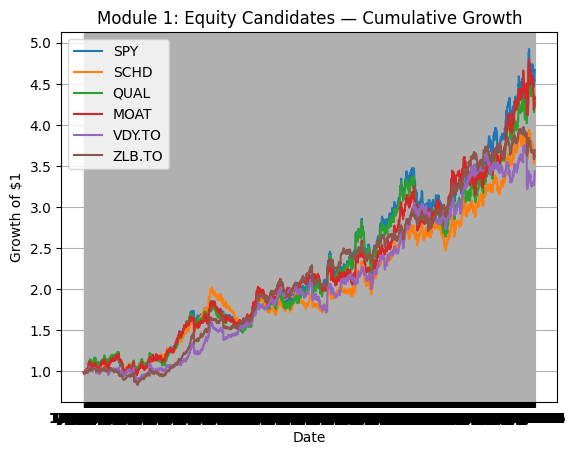

In [18]:
def equity_curve(r):
    return (1 + r.fillna(0)).cumprod()

plt.figure()
for t in equity_candidates:
    plt.plot(equity_curve(returns_wide[t]), label=t)

plt.title("Module 1: Equity Candidates — Cumulative Growth")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()

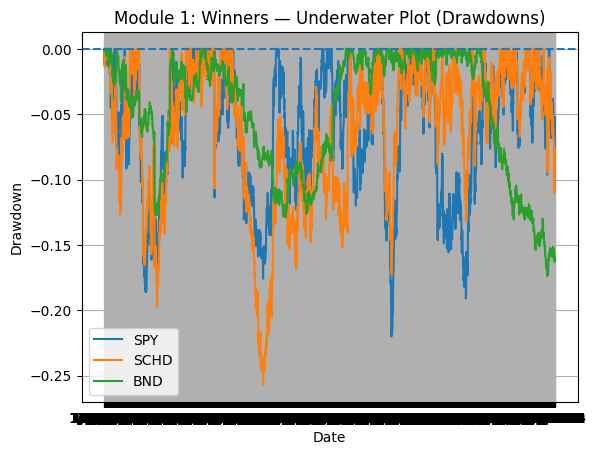

In [19]:
def drawdown_series(r):
    eq = (1 + r.fillna(0)).cumprod()
    peak = eq.cummax()
    return (eq / peak - 1)

plt.figure()
for t in winners:
    plt.plot(drawdown_series(returns_wide[t]), label=t)

plt.axhline(0, linestyle="--")
plt.title("Module 1: Winners — Underwater Plot (Drawdowns)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.show()


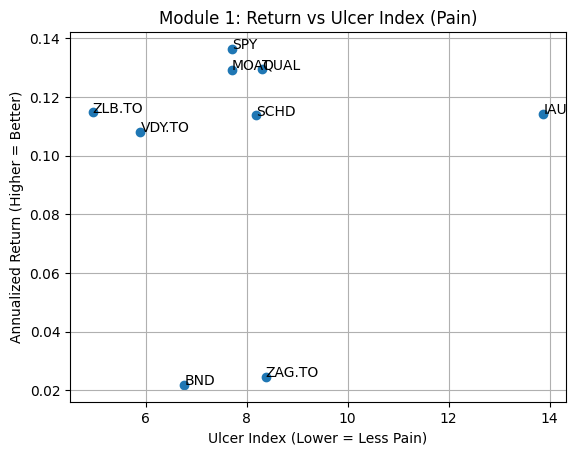

In [20]:
plt.figure()
x = metrics_df["Ulcer Index"]
y = metrics_df["Annualized Return"]

plt.scatter(x, y)

for etf in metrics_df.index:
    plt.text(x.loc[etf], y.loc[etf], etf)

plt.title("Module 1: Return vs Ulcer Index (Pain)")
plt.xlabel("Ulcer Index (Lower = Less Pain)")
plt.ylabel("Annualized Return (Higher = Better)")
plt.grid(True)
plt.show()

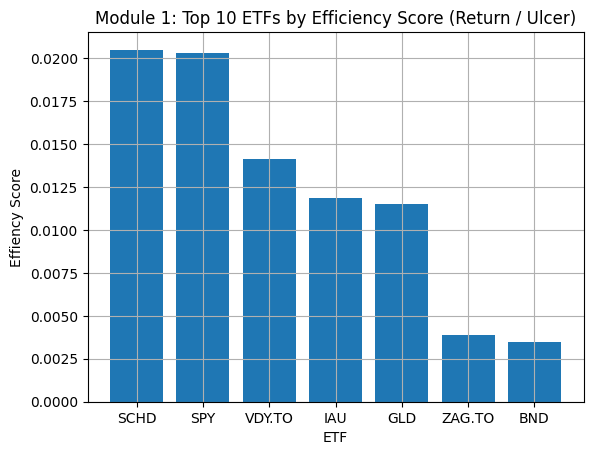

In [19]:
top10 = metrics_df.sort_values("Efficiency Score", ascending=False).head(10)

plt.figure()
plt.bar(top10.index, top10["Efficiency Score"])
plt.title("Module 1: Top 10 ETFs by Efficiency Score (Return / Ulcer)")
plt.xlabel("ETF")
plt.ylabel("Effiency Score")
plt.grid(True)
plt.show()

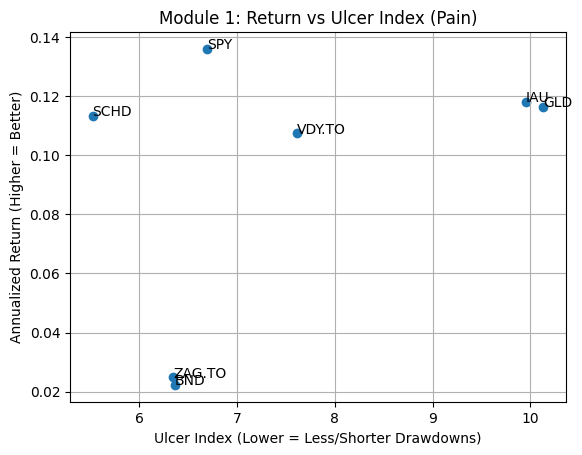

In [20]:
plt.figure()
x = metrics_df["Ulcer Index"]
y = metrics_df["Annualized Return"]
plt.scatter(x, y)

for etf in metrics_df.index:
    plt.text(x.loc[etf], y.loc[etf], etf)

plt.title("Module 1: Return vs Ulcer Index (Pain)")
plt.xlabel("Ulcer Index (Lower = Less/Shorter Drawdowns)")
plt.ylabel("Annualized Return (Higher = Better)")
plt.grid(True)
plt.show()


- Left = less pain, up = more reward
- Best ETFs sit upper left
- thats why return/ulcer is a clean effiency score

The Story:
- SPY (Top Right): Makes the most money, but sits far to the right. It is "High Stress."
- SCHD (Top Left-ish): This is your Winner. It is nearly as high up as SPY (good return) but significantly to the left (less pain). It is the "Efficient" choice.
- BND (Bottom): Low return and, surprisingly, historically high pain recently. It is currently the "Worst of both worlds."

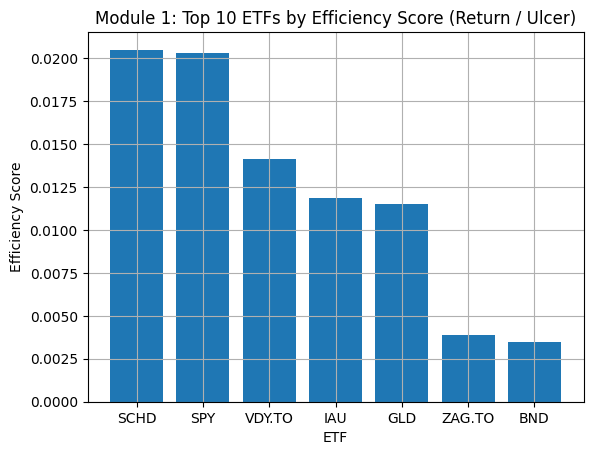

In [21]:
top10 = metrics_df.sort_values("Efficiency Score", ascending=False).head(10)

plt.figure()
plt.bar(top10.index, top10["Efficiency Score"])
plt.title("Module 1: Top 10 ETFs by Efficiency Score (Return / Ulcer)")
plt.xlabel("ETF")
plt.ylabel("Efficiency Score")
plt.grid(True)
plt.show()

divide "Return" by "Pain." A taller bar means you are getting a better deal.

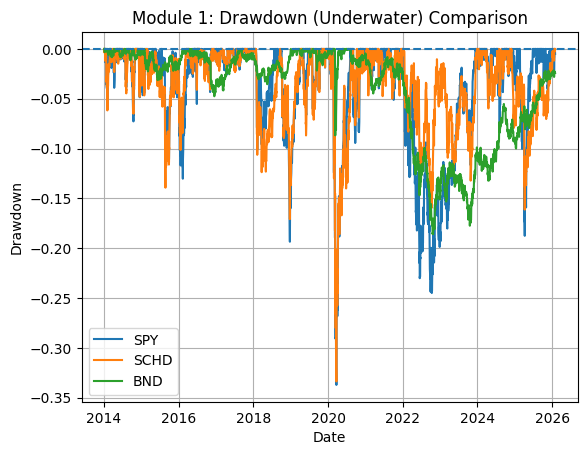

In [22]:
def drawdown_series(r):
    eq = (1 + r.fillna(0)).cumprod()
    peak = eq.cummax()
    return (eq / peak - 1)

compare = [t for t in ["SPY","SCHD","USMV","QUAL","BND"] if t in returns_wide.columns]

plt.figure()
for t in compare:
    plt.plot(drawdown_series(returns_wide[t]), label=t)

plt.axhline(0, linestyle="--")
plt.title("Module 1: Drawdown (Underwater) Comparison")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.show()


- Blue Line (SPY): Deep dives. It goes down fast and hard.
- Orange Line (SCHD): Notice that in many crashes, the Orange line doesn't go as deep as the Blue line. It is a "life jacket"—you still get wet, but you don't drown.
- Green Line (BND): Look at the right side (2022-present). It went deep underwater and stayed there. It hasn't recovered. This scares passive investors.

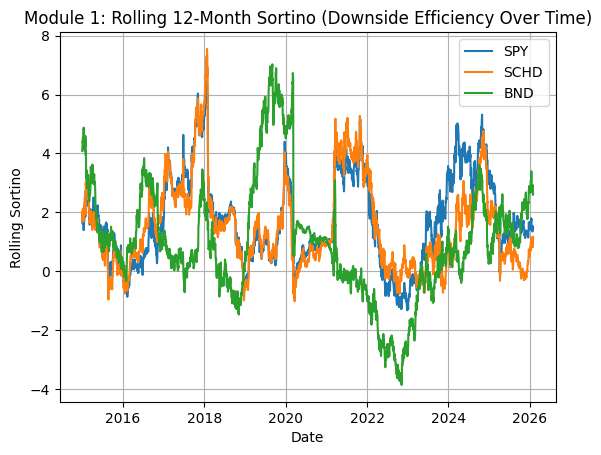

In [23]:
TRADING_DAYS = 252

def rolling_sortino(r, window=252, mar_annual=0.0):
    mar_daily = (1 + mar_annual)**(1/TRADING_DAYS) - 1
    out = []
    idx = r.dropna().index
    r = r.dropna()
    for i in range(window, len(r)+1):
        chunk = r.iloc[i-window:i]
        downside = np.minimum(chunk - mar_daily, 0.0)
        downside_dev = downside.std(ddof=0) * np.sqrt(TRADING_DAYS)
        ann_excess = (chunk.mean() - mar_daily) * TRADING_DAYS
        out.append(ann_excess / downside_dev if downside_dev != 0 else np.nan)
    return pd.Series(out, index=idx[window-1:])

winners = [t for t in ["SPY","SCHD","BND"] if t in returns_wide.columns]

plt.figure()
for t in winners:
    rs = rolling_sortino(returns_wide[t], window=252)
    plt.plot(rs, label=t)

plt.title("Module 1: Rolling 12-Month Sortino (Downside Efficiency Over Time)")
plt.xlabel("Date")
plt.ylabel("Rolling Sortino")
plt.legend()
plt.grid(True)
plt.show()


- this shows if the etf stay efficient consistenly, not only on average

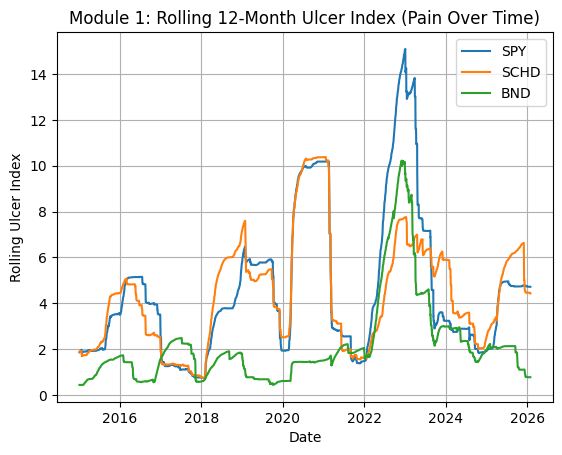

In [24]:
def rolling_ulcer(r, window=252):
    r = r.dropna()
    out = []
    idx = r.index
    for i in range(window, len(r)+1):
        chunk = r.iloc[i-window:i]
        eq = (1 + chunk).cumprod()
        peak = eq.cummax()
        dd_pct = (eq / peak - 1) * 100.0
        out.append(np.sqrt(np.mean(dd_pct**2)))
    return pd.Series(out, index=idx[window-1:])

plt.figure()
for t in [x for x in ["SPY","SCHD","USMV","BND"] if x in returns_wide.columns]:
    ru = rolling_ulcer(returns_wide[t], window=252)
    plt.plot(ru, label=t)

plt.title("Module 1: Rolling 12-Month Ulcer Index (Pain Over Time)")
plt.xlabel("Date")
plt.ylabel("Rolling Ulcer Index")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
ru_spy = rolling_ulcer(returns_wide["SPY"], window=252)
print("First rolling date:", ru_spy.index.min())
print("Original data start:", returns_wide.index.min())

First rolling date: 2015-01-02 00:00:00
Original data start: 2014-01-03 00:00:00
